In [1]:
import numpy as np
import numba as nb

import time
import matplotlib.pyplot as plt
import socket

from IPython import display

In [2]:
hx = hy = 18

buffer = np.zeros((hx, hy, 3), dtype='uint8')
buffer.shape

(18, 18, 3)

In [5]:
offset = hx * (hy // 2)

packet_1 = np.concatenate([np.array([0x04, 0xff, 0x00, 0x00], dtype='uint8'), 
                           np.zeros(offset * 3 , dtype='uint8')])
packet_2 = np.concatenate([np.array([0x04, 0xff, offset // 256,  offset  % 256], dtype='uint8'), 
                           np.zeros(offset * 3 , dtype='uint8')])

In [6]:
16 * 16 * 3  // 2

384

In [108]:
@nb.njit
def effect(buffer, t):
    for x in range(hx):
        for y in range(hy):
            dx = x / (hx)
            dy = y / (hy)
            buffer[x,y,0] = np.cos( dx * 2 + dy ** 2 * 6 + t) * 128 + 128
            buffer[x,y,1] = np.sin( dx * 4 + np.cos(t*1.42) ) * np.cos( (dy + np.sin(t*1.23)) * 3 ) * np.sin(t * 2.13) * 128 + 128
            buffer[x,y,2] = np.sin( dx ** 3 * 6 * np.cos(t*1.111) + dy * 4 + t * 3) * 128 + 128

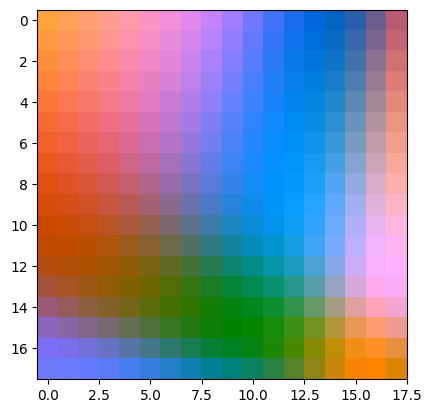

In [109]:
# Preview
for _ in range(100):
    t = time.time()

    effect(buffer, t)
    
    p = plt.imshow(buffer)
    display.clear_output(wait=True)
    plt.show(p)
    time.sleep(.012)

In [110]:
IP = '192.168.2.219'
#IP = '192.168.2.203'

PORT = 21324
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

In [112]:
# Real loop
n = 0
t0 = time.time()

while True:
    n+=1
    t = time.time()
    effect(buffer, t)
    
    if not n % 100:
        rate = 100 / (t - t0)
        t0 = time.time()
        print(f'sending rate={rate}, fr={n} ', end='\r', flush=True)

    packet_1[4:] = buffer[:hy//2, :, :].flatten()
    packet_2[4:] = buffer[hy//2:, :, :].flatten()

    sock.sendto(packet_1.data, (IP, PORT))
    sock.sendto(packet_2.data, (IP, PORT))

    diff = time.time() - t
    if diff > .01:
        print(n, diff, '')
        
    if diff < .012:
        time.sleep(0.012 - diff)

OSError: [Errno 65] No route to host

In [ ]:
786 * 3